# [S24] Introduction to Machine Learning: Bonus assignment
**Student name:** <font color='red'>Danil Davydov</font>

**Student email:** <font color='red'>d.davydov@innopolis.university</font>

In [1]:
# import libraries
import torch
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization
import keras.layers as layers
from keras.datasets import cifar10
import tensorflow as tf
import torch.nn as nn
import torch.functional as F
from sklearn.model_selection import train_test_split
from  keras.utils import to_categorical
from keras.callbacks import EarlyStopping

2024-05-01 09:47:25.329085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 09:47:26.544586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Task 1. Baseline model [0pt]

In [2]:
class CNN_from_scratch(nn.Module):
    """
    CNN from scratch from main task 2
    """
    def __init__(self):
        super(CNN_from_scratch, self).__init__()
        self.conv0 = nn.Conv2d(3, 32, (3,3), padding="same")
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.activation0 = nn.ReLU()
        self.pool0 = nn.MaxPool2d((2, 2))
        self.dropout0 = nn.Dropout(0.25)

        self.conv1 = nn.Conv2d(32, 64, (3,3), padding="same")
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.activation1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2, 2))
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 64, (3,3), padding="same")
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.activation2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2, 2))
        self.dropout2 = nn.Dropout(0.25)

        self.flat = nn.Flatten()
        self.linear0 = nn.Linear(64*16, 512)
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.output = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = self.batchnorm0(x)
        x = self.activation0(x)
        x = self.pool0(x)
        x = self.dropout0(x)

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flat(x)
        x = self.linear0(x)
        x = self.batchnorm3(x)
        x = self.activation3(x)
        x = self.dropout3(x)

        x = self.output(x)
        return x


In [3]:
# using gpu with cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# loading baseline model
baseline_model = CNN_from_scratch().to(device)
baseline_model.load_state_dict(torch.load("from_scratch.pt", map_location=device))

<All keys matched successfully>

In [5]:
# freezing layers
for parameter in baseline_model.parameters():
  parameter.requires_grad = False

## Task 2. Self-supervised learning [12pts]

In [6]:
# collecting x_train and x_test for autoencoder
(x_train, _ ), (x_test, _) = cifar10.load_data()

In [7]:
# data augmentation for dataset images
data_augmentation_train = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.Rescaling(1./255),
])

data_augmentation_test = tf.keras.Sequential([
    layers.Rescaling(1./255),
])
x_train = data_augmentation_train(x_train)
x_test = data_augmentation_test(x_test)

2024-05-01 09:47:30.431662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31114 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0


In [8]:
# images shape
input_shape = x_train[0].shape

In [9]:
input_shape

TensorShape([32, 32, 3])

In [10]:
def create_encoder(input_shape):
    """
    Creates encoder part
    :param input_shape shape of the input image
    :returns input_image, encoded input layer and encoder layers
    """
    input_image = Input(shape=input_shape)
    encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name="encoded")(encoded)
    return input_image, encoded

def create_decoder(encoded):
    """
    Creates decoder part
    :param encoded encoder layers
    :returns decoded layers
    """
    decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name="decoded")(decoded)
    return decoded

def create_classification(encoded):
    """
    Creates classification part
    :param encoded encoder layers
    :returns classification layers
    """
    classify = Flatten()(encoded)
    classify = Dense(256, activation='relu')(classify)
    classify = BatchNormalization()(classify)
    classify = Dropout(0.5)(classify)
    classify = Dense(64, activation='relu')(classify)
    classify = BatchNormalization()(classify)
    classify = Dropout(0.25)(classify)
    classify = Dense(10, activation='softmax', name="classify")(classify)
    return classify

In [11]:
# creating autoencoder
input_image, encoded = create_encoder(input_shape)
decoded = create_decoder(encoded)
autoencoder = Model(inputs=input_image, outputs=decoded)

In [12]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 encoded (Conv2D)            (None, 16, 16, 16)        4624      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                                           

In [13]:
# training the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=20, verbose=True)

Epoch 1/20


2024-05-01 09:47:33.994660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2024-05-01 09:47:34.436033: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f77275929d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 09:47:34.436093: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-05-01 09:47:34.444424: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 09:47:34.635662: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 11s 5ms/step - loss: 0.0048 - accuracy: 0.7475
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0016 - accuracy: 0.8182
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0012 - accuracy: 0.8321
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0011 - accuracy: 0.8384
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 9.6232e-04 - accuracy: 0.8430
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 8.9227e-04 - accuracy: 0.8468
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 8.4060e-04 - accuracy: 0.8493
Epoch 8/20
1563/1563 [==============================] - 8s 5ms/step - loss: 7.9437e-04 - accuracy: 0.8517
Epoch 9/20
1563/1563 [==============================] - 8s 5ms/step - loss: 7.6023e-04 - accuracy: 0.8532
Epoch 10/20
1563/1563 [==============================] - 8s 5ms/step - l

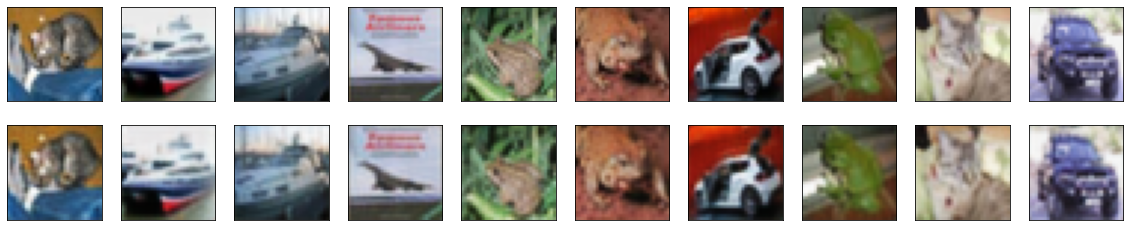

In [14]:
# displaying images before and after autoencoder, images below went through the autoencoder
import matplotlib.pyplot as plt
def display_images(original, decoded, count = 10):
    n = count
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # show original input image
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display decoded image
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_images(x_test, autoencoder.predict(x_test, verbose=False))

In [15]:
# creating classification model with frozen layers of encoder from autoencoder
input_image, encoded = create_encoder(input_shape)
classify = create_classification(encoded)
classifier = Model(inputs=input_image, outputs=classify)
i = 0
while autoencoder.layers[i].name != "encoded":
    layer = autoencoder.layers[i]
    classifier.layers[i].trainable = False  # Freeze encoder layers
    classifier.layers[i].set_weights(layer.get_weights())
    i += 1
layer = autoencoder.layers[i]
classifier.layers[i].trainable = False  # Freeze encoder layers
classifier.layers[i].set_weights(layer.get_weights())

In [16]:
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 encoded (Conv2D)            (None, 16, 16, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1048832   
                                                           

In [17]:
# loading data again
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [18]:
# change labels to binary format
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [19]:
# getting 10 percent sample from train dataset
x_train_10, _, y_train_10, _ = train_test_split(x_train, y_train, train_size=0.1, stratify=y_train)
x_train_10 = data_augmentation_train(x_train_10)
x_train = data_augmentation_train(x_train)
x_test = data_augmentation_test(x_test)

In [20]:
# declare scheduler, early stopping and optimizer for training the model
scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=0.000001
)
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True)
adam = keras.optimizers.Adam(learning_rate=0.0001)

In [21]:
# training the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history = classifier.fit(x_train_10, y_train_10, epochs=50, verbose=True, validation_data=(x_test, y_test), callbacks=[callback, scheduler])

Epoch 1/50
157/157 [==============================] - 5s 14ms/step - loss: 2.2936 - accuracy: 0.2448 - val_loss: 3.5919 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 2/50
157/157 [==============================] - 2s 11ms/step - loss: 1.9346 - accuracy: 0.3292 - val_loss: 1.9967 - val_accuracy: 0.3381 - lr: 0.0010
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 1.8183 - accuracy: 0.3584 - val_loss: 1.8605 - val_accuracy: 0.3502 - lr: 0.0010
Epoch 4/50
157/157 [==============================] - 2s 11ms/step - loss: 1.7401 - accuracy: 0.3828 - val_loss: 1.7075 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 5/50
157/157 [==============================] - 2s 11ms/step - loss: 1.6607 - accuracy: 0.4124 - val_loss: 1.7650 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 6/50
155/157 [============================>.] - ETA: 0s - loss: 1.5957 - accuracy: 0.4425
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
157/157 [==============================] - 2s 1

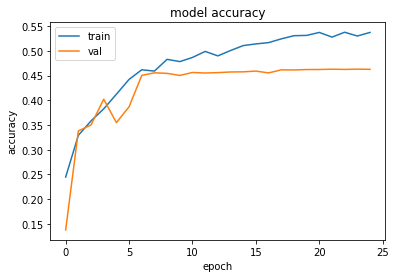

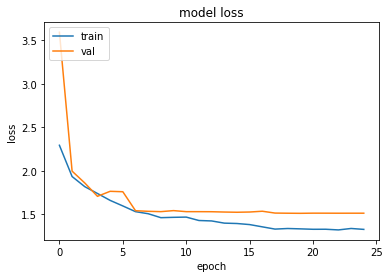

In [22]:
# plotting model accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Task 3. Auxiliary learning [12 pts]

In [23]:
# making model for an auxilary learning
input_image, encoded = create_encoder(input_shape)
classify = create_classification(encoded)
decoded = create_decoder(encoded)
aux_model = Model(inputs=input_image, outputs=[decoded, classify])

aux_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 encoded (Conv2D)               (None, 16, 16, 16)   4624        ['max_pooling2d_2[0][0]']        
                                                                                            

In [24]:
# declaring scheduler, early stopping, optimizer for training
scheduler_aux = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_classify_loss',
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=0.00001
)
callback_aux = EarlyStopping(monitor='val_classify_loss', patience=5, verbose=True)
adam = keras.optimizers.Adam(learning_rate=0.0001)

# train the model
aux_model.compile(optimizer=adam,
               loss={'decoded': 'mse', 'classify': 'categorical_crossentropy'},
               metrics={'decoded': 'accuracy', 'classify': 'accuracy'})
history_aux = aux_model.fit(x_train_10, {'decoded': x_train_10, 'classify': y_train_10},
              epochs=50, batch_size=32,
              validation_data=( x_test, {'decoded': x_test,'classify': y_test}), callbacks=[callback_aux, scheduler_aux])


Epoch 1/50
157/157 [==============================] - 4s 17ms/step - loss: 2.7248 - decoded_loss: 0.0633 - classify_loss: 2.6615 - decoded_accuracy: 0.2699 - classify_accuracy: 0.1794 - val_loss: 2.2032 - val_decoded_loss: 0.0580 - val_classify_loss: 2.1452 - val_decoded_accuracy: 0.2918 - val_classify_accuracy: 0.2255 - lr: 1.0000e-04
Epoch 2/50
157/157 [==============================] - 2s 14ms/step - loss: 2.3348 - decoded_loss: 0.0519 - classify_loss: 2.2830 - decoded_accuracy: 0.3826 - classify_accuracy: 0.2506 - val_loss: 2.0758 - val_decoded_loss: 0.0434 - val_classify_loss: 2.0324 - val_decoded_accuracy: 0.4724 - val_classify_accuracy: 0.2774 - lr: 1.0000e-04
Epoch 3/50
157/157 [==============================] - 2s 14ms/step - loss: 2.0957 - decoded_loss: 0.0369 - classify_loss: 2.0588 - decoded_accuracy: 0.5265 - classify_accuracy: 0.3096 - val_loss: 1.8805 - val_decoded_loss: 0.0303 - val_classify_loss: 1.8502 - val_decoded_accuracy: 0.5403 - val_classify_accuracy: 0.3408 - l

In [25]:
# Extract necessary metrics and plot them
train_loss = history_aux.history['loss']
train_classify_loss = history_aux.history['classify_loss']
train_decoded_loss = history_aux.history['decoded_loss']


val_loss = history_aux.history['val_loss']
val_classify_loss = history_aux.history['val_classify_loss']
val_decoded_loss = history_aux.history['val_decoded_loss']

val_classify_acc = history_aux.history['val_classify_accuracy']
classify_acc = history_aux.history['classify_accuracy']

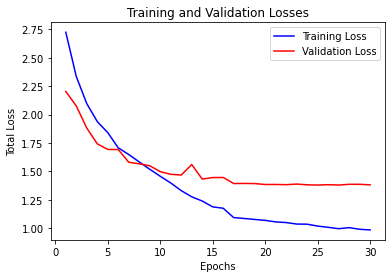

In [26]:
# Plot train and test losses
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

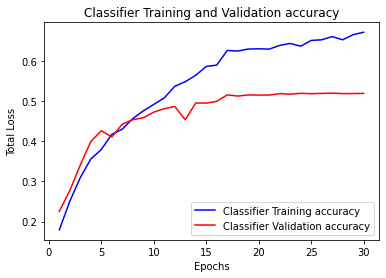

In [27]:
# plotting classsifier accuracy
plt.plot(epochs, classify_acc, 'b', label='Classifier Training accuracy')
plt.plot(epochs, val_classify_acc, 'r', label='Classifier Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Classifier Training and Validation accuracy')
plt.legend()
plt.show()

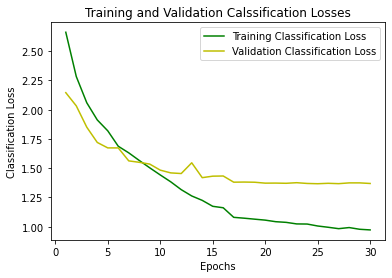

In [28]:
# plotting classification losses
plt.plot(epochs, train_classify_loss, 'g', label='Training Classification Loss')
plt.plot(epochs, val_classify_loss, 'y', label='Validation Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Classification Loss')
plt.title('Training and Validation Calssification Losses')
plt.legend()
plt.show()

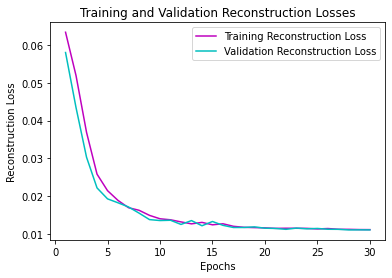

In [29]:
# plotting reconstruction losses
plt.plot(epochs, train_decoded_loss, 'm', label='Training Reconstruction Loss')
plt.plot(epochs, val_decoded_loss, 'c', label='Validation Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.title('Training and Validation Reconstruction Losses')
plt.legend()
plt.show()

## Task 4. Ensemble [6pts]